#### Here we have used a simple bayesian inference to estimate the transit depth and fit it over the spectrum to get the new final spectrum

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 

import h5py

from scipy.ndimage import gaussian_filter1d

In [2]:
import batman   # for estimating the transit
import emcee  # to sample posterior using monte-carlo Markov Chains 

In [3]:
def meta_loader(planet_id):
    '''
    Loads the meta data for the exoplanet and its star: \n
    Input : planet_id : exoplanet ID \n
    
    returns : Meta data of the exoplanet and its star -> series
    '''
    
    df_meta = pd.read_csv(data_dir + "/train_star_info.csv")
    return df_meta[df_meta["planet_id"] == planet_id]

### Defining the transit model

In [4]:
def transit_depth_model(time, per,rp, t1, t2, a, inc, ecc, u1, u2, drift_slope=0.0):
    """
    Transit + linear gain drift model.

    Parameters
    ----------
    time : array
        Time vector.
    per : float
        Orbital period.
    t1, t2 : float
        Ingress and egress times (used to set t0).
    a : float
        Semi-major axis in stellar radii.
    inc : float
        Inclination in degrees.
    ecc : float
        Eccentricity.
    drift_slope : float
        Linear drift slope (fractional flux per unit time).

    Returns
    -------
    model_flux : array
        Transit light curve with linear gain drift applied.
    """
    params = batman.TransitParams()
    params.t0 = (t1 + t2) / 2.0     # mid-transit
    params.per = per
    params.rp = rp                # planet radius (placeholder, will fit)
    params.a = a                  # semi-major axis
    params.inc = inc                # inclination
    params.ecc = ecc               # eccentricity
    params.w = 90.                 
    params.u = [u1, u2]           # limb darkening coefficients
    params.limb_dark = "quadratic"     # limb darkening polynomial

    # Get transit model
    m = batman.TransitModel(params, time, transittype="primary")
    transit_flux = m.light_curve(params)     # creating a light curve

    # Apply linear gain drift
    t_mean = np.mean(time)
    gain_drift = 1.0 + drift_slope * (time - t_mean)

    return transit_flux * gain_drift

## Bayesian parameter estimation 

### Defining priors

Defing priors for the fgs sensor

In [5]:
def lnprior_fgs(theta):
    '''
    Defining the hypothesis (prior)

    rp --> uniform prior
    lp --> gaussian log prior
    
    '''
    rp, drift_slope, u1, u2 = theta

    # Applying boundary conditions

    if not (0.0 < rp < 0.5):   
        return -np.inf

    if not (-1e-2 < drift_slope < 1e-2):  
        return -np.inf
        
    # limb darkening coefficients 
    if not (0.0 < u1 < 1.0):   # uniform prior 
        return -np.inf
    if not (0.0 < u2 < 1.0):
        return -np.inf

    # defining gaussian prior centred at 0 (mean = 0)
    lp = -0.5 * (drift_slope/1e-3)**2

    return lp

Defining priors for the AIRS sensor

In [6]:
def lnprior_airs(theta, n_chan):
    # unpack
    rp = np.array(theta[0:n_chan])
    drift_slope = theta[n_chan]
    g_lambda = np.array(theta[n_chan+1:n_chan+1+n_chan])
    u1 = theta[-2]
    u2 = theta[-1]

    # bounds
    if np.any((rp <= 0.0) | (rp >= 0.5)):
        return -np.inf
    if not (-1e-2 < drift_slope < 1e-2):
        return -np.inf
    if np.any((g_lambda < 0.8) | (g_lambda > 1.2)):   # allow ±20%
        return -np.inf
    if not (0.0 < u1 < 1.0):   # uniform prior 
        return -np.inf
    if not (0.0 < u2 < 1.0):
        return -np.inf

    # Priors: uniform bounds implied above; gaussian prior on drift; gaussian on g_lambda around 1
    lp = 0.0
    lp += -0.5 * (drift_slope / 1e-3)**2
    lp += -0.5 * np.sum(((g_lambda - 1.0)/0.05)**2)   # sigma_g ~0.05

    return lp

#### Defining the flux error (variance)

In [7]:
def detect_edges(signal):
    """
    Detect ingress and egress edges in a light curve using 
    Gaussian derivative filtering.
    
    Parameters:
        signal : 1D array
            Input light curve (flux vs. time).
        sigma : float
            Gaussian smoothing width.

    Returns:
        ingress_edge_1, ingress_edge_2, egress_edge_1, egress_edge_2 : int
            Indices for ingress/egress edges.
        derivative_first : 1D array
            First derivative of smoothed signal.
        derivative_second : 1D array
            Second derivative of smoothed signal.
    """

    # --- Step 1: normalize around median ---
    signal = (signal - np.median(signal)) / np.median(signal)

    # --- Step 2: derivatives ---
    derivative_first = gaussian_filter1d(signal, sigma= 3, order=1)
    derivative_second = gaussian_filter1d(signal, sigma= 5, order=2)

    # --- Step 3: ingress/egress centers ---
    ingress_centre_index = np.argmin(derivative_first)
    egress_centre_index = np.argmax(derivative_first)

    # --- Step 4: split second derivative ---
    first_half = derivative_second[:len(derivative_second)//2]
    second_half = derivative_second[len(derivative_second)//2:]

    ingress_edge_1 = np.argmin(first_half)
    ingress_edge_2 = np.argmax(first_half)

    egress_edge_1 = np.argmax(second_half) + len(first_half) - 1
    egress_edge_2 = np.argmin(second_half) + len(first_half) - 1

    return ingress_edge_1, ingress_edge_2, egress_edge_1, egress_edge_2

In [8]:
def oot_region_masking(n_time, ingress_start, egress_end):
    oot_mask = np.ones(n_time, dtype = bool)
    oot_mask[ingress_start: egress_end + 1] = False

    return oot_mask

In [9]:
def flux_err(flux, n_time, ingress_start, egress_end):
    '''
    Returns flux error variance for given signal imagery
    '''
    def oot_region_masking(n_time, ingress_start, egress_end):
        oot_mask = np.ones(n_time, dtype = bool)
        oot_mask[ingress_start: egress_end + 1] = False

        return oot_mask
    
    flux_oot = flux[oot_region_masking(n_time, ingress_start, egress_end), :]

    flux_error = np.std(flux_oot, axis = 0)

    return flux_error

#### Defining the white noise gaussian log likelihood

In [10]:
def lnlike(signal_original, flux_err, theta, time, per, t1, t2, a ,ecc, inc, n_chan, sensor):

    if sensor.lower() == "fgs":
        # unpacking theta 
        rp = theta[0]
        drift_slope = theta[1]
        u1, u2 = theta[2], theta[3]

        model = transit_depth_model(time = time, per = per, rp = rp, t1 = t1, t2 = t2, a = a, 
                                    ecc = ecc, inc = inc, u1 = u1, u2 = u2, drift_slope = drift_slope)

        # Gaussian log likelihood (whitenoise)

        residual = signal_original - model
        exp_term = (residual)**2/flux_err**2

        log_like = - 0.5 * np.sum(exp_term + np.log(2 * np.pi * flux_err ** 2))

    elif sensor.lower() == "airs":
        rp = np.array(theta[:n_chan])
        drift_slope = theta[n_chan]
        g_lambda = np.array(theta[n_chan+1:n_chan+1+n_chan])
        u1, u2 = theta[-2], theta[-1] 

        flux_model = np.zeros_like(signal_original)
        
        for i in range(n_chan):   # creating the model for all wavelength channels 
            transit_model = transit_depth_model(time = time, per = per, rp = rp[i], 
                                                t1 = t1, t2 = t2, a = a, 
                                                ecc = ecc, inc = inc, u1 = u1, u2 = u2, drift_slope = drift_slope)

            flux_model[:, i] = transit_model * g_lambda[i]

        residual = signal_original - flux_model
        exp_term = (residual ** 2)/flux_err ** 2

        log_like = - 0.5 * np.sum(exp_term + np.log(2 * np.pi * flux_err ** 2))

    return log_like

Sampling posterior using Monte-Carlo Markov Chains

Defining the posterior

In [11]:
def lnprob(theta, signal_original, flux_err, time, per, t1, t2, a, ecc, inc, n_chan, sensor):
    if sensor.lower() == "fgs":
        lp = lnprior_fgs(theta)
    elif sensor.lower() == "airs":
        lp = lnprior_airs(theta, n_chan)

    if not np.isfinite(lp):
        return -np.inf

    ll = lnlike(signal_original, flux_err, theta, time, per, t1, t2, a, ecc, inc, n_chan, sensor)
    return lp + ll

Setting up the MCMC sampler 

In [12]:
def posterior_sampling(sensor, signal_original, flux_err, time, per, t1, t2, a, ecc, inc, n_chan):
    if sensor.lower() == "fgs":
        ndim = 4   # rp, drift, u1, u2
        nwalkers = 8
        nsteps = 1

        # initialize walkers around small values
        p0 = np.random.normal(0.1, 0.01, size=(nwalkers, ndim))

        sampler = emcee.EnsembleSampler(
            nwalkers, ndim, lnprob,
            args=(signal_original, flux_err, time, per, t1, t2, a, ecc, inc, n_chan, "fgs")
        )

    elif sensor.lower() == "airs":
        ndim = 2 * n_chan + 3   # rp’s + drift + g_lambda’s + u1 + u2
        nwalkers = 2 * ndim
        nsteps = 1

        # initialize: rp ~ 0.1, g_lambda ~ 1.0, u1,u2 ~ 0.3
        p0 = np.zeros((nwalkers, ndim))
        p0[:, :n_chan] = np.random.normal(0.1, 0.01, size=(nwalkers, n_chan))          # rp
        p0[:, n_chan] = np.random.normal(0.0, 1e-4, size=nwalkers)                     # drift_slope
        p0[:, n_chan+1:n_chan+1+n_chan] = np.random.normal(1.0, 0.01, size=(nwalkers, n_chan)) # g_lambda
        p0[:, -2] = np.random.uniform(0.2, 0.6, size=nwalkers)                         # u1
        p0[:, -1] = np.random.uniform(0.2, 0.6, size=nwalkers)                         # u2

        sampler = emcee.EnsembleSampler(
            nwalkers, ndim, lnprob,
            args=(signal_original, flux_err, time, per, t1, t2, a, ecc, inc, n_chan, "airs")
        )

    print("Running MCMC...")
    sampler.run_mcmc(p0, nsteps, progress=True)

    samples = sampler.get_chain(discard=500, thin=10, flat=True)
    return samples

Running test on planets

In [13]:
import h5py

In [ ]:
with h5py.File("/kaggle/input/ariel-preprocessedvyom/combined.h5") as data_file:
    print(data_file.keys())
    airs_clean_train = data_file['airs_train']
    airs_clean_train = np.array(airs_clean_train)
   
    for i in range(30):
        signal = airs_clean_train[i,:,:].sum(axis = 1)
        signal = (signal - np.median(signal)) / np.median(signal)
        plt.plot(signal)


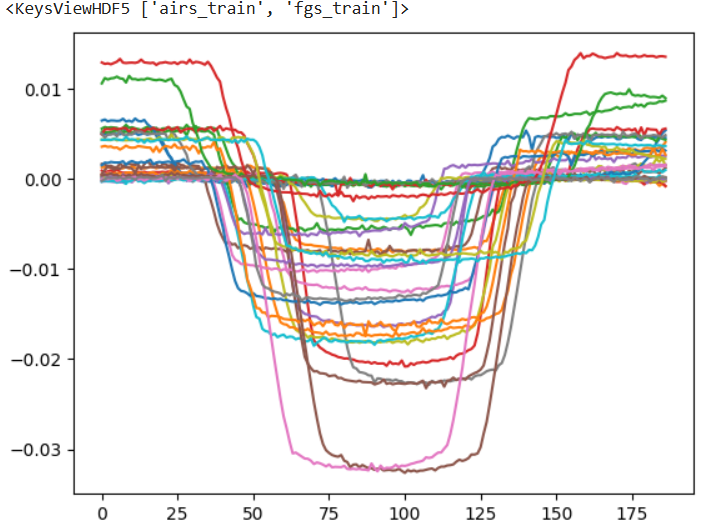

In [ ]:
with h5py.File("/kaggle/input/ariel-preprocessedvyom/combined.h5") as data_file:
    print(data_file.keys())
    fgs_clean_train = data_file['fgs_train']
    fgs_clean_train = np.array(fgs_clean_train)
    
   
    for i in range(30):
        signal = fgs_clean_train[i,:,:].sum(axis = 1)
        signal = (signal - np.median(signal)) / np.median(signal)
        plt.plot(signal)

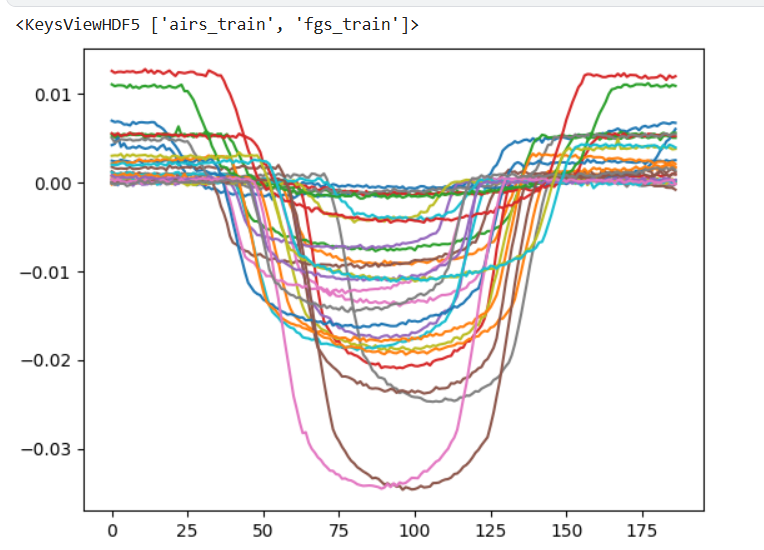

Running the posterior sampler on the first planet

In [ ]:
with h5py.File("/kaggle/input/ariel-preprocessedvyom/combined.h5") as data_file:
    print(data_file.keys())
    fgs_clean_train = np.array(data_file['fgs_train'])
    signal_original = fgs_clean_train[0]

    # edge detection
    ingress_1, ingress_2, egress_1, egress_2 = detect_edges(signal_original.sum(axis=1))

    # planet meta
    per  = float(meta_loader(34983)["P"])
    t1   = ingress_1
    t2   = egress_2
    a    = float(meta_loader(34983)["sma"])
    ecc  = float(meta_loader(34983)["e"])
    inc  = float(meta_loader(34983)["i"])
    n_chan = signal_original.shape[1]

    # flux error
    flux_error = flux_err(
        flux=signal_original,
        n_time=signal_original.shape[0],
        ingress_start=ingress_1,
        egress_end=egress_2
    )

    # time vector (temporary placeholder if no dataset provided)
    time = np.arange(signal_original.shape[0])

    # posterior sampling
arr = posterior_sampling(
        sensor="fgs",
        signal_original=signal_original,
        flux_err=flux_error,
        time=time,
        per=per,
        t1=t1,
        t2=t2,
        a=a,
        ecc=ecc,
        inc=inc,
        n_chan=n_chan
    )
print(arr)